In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# jt -t monokai -N -T -kl -nfs 10 -tfs 10
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

In [2]:
#export
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import os
import pandas as pd
import matplotlib.pyplot as plt
import types

## Let's start with DataLoaders and stuff...

In [3]:
# base path and csv for train and validation sets
path = os.path.abspath('/home/marco/workspace/musical-genre-from-pianorolls/piano_rolls')
train_valid_df = pd.read_csv(path+'/train_valid.csv')
train_valid_df.head()

trackId   Target  Valid
0  TRAAAGR128F425B14B      pop  False
1  TRAADKW128E079503A  poprock   True
2  TRAAFMT128F429DB58  poprock   True
3  TRAAGMC128F4292D0F  country  False
4  TRAALAH128E078234A  poprock  False

In [4]:
uniques_genres = list(set(train_valid_df['Target']))

In [5]:
dd = dict(enumerate(uniques_genres))
print(dd)

{0: 'electronic', 1: 'newage', 2: 'rnb', 3: 'easylistening', 4: 'instrumentals', 5: 'freestyle', 6: 'lounge', 7: 'poprock', 8: 'oldies', 9: 'trance', 10: 'rap', 11: 'house', 12: 'reggae', 13: 'metal', 14: 'comedy', 15: 'world', 16: 'pop', 17: 'soundtrack', 18: 'dance', 19: 'hiphop', 20: 'folk', 21: 'instrumental', 22: 'country', 23: 'blues', 24: 'vocal', 25: 'religious', 26: 'christmas', 27: 'gospel', 28: 'other', 29: 'cover', 30: 'jazz', 31: 'classical', 32: 'international', 33: 'soul', 34: 'rock', 35: 'latin', 36: 'children', 37: 'stage', 38: 'techno'}


In [6]:
#export
# Some simple functions to grab and visualize pianoroll and optionally print its genre
def load_piano_roll(song_name, base_path):
    t_indices = torch.load(base_path+'/'+song_name+'_indices.pt')
    t_values = torch.load(base_path+'/'+song_name+'_values.pt')
    t_sizes = torch.load(base_path+'/'+song_name+'_sizes.pt')
    return torch.sparse_coo_tensor(t_indices, t_values, t_sizes).to_dense()

def plot_piano_roll(piano_roll, genre = None, title = None):
    squished_pr = torch.sum(piano_roll, dim=0).squeeze(0)[:,3000:3500] # small subset
    plt.matshow(squished_pr)
    if genre:
        if title:
            plt.title(title + ' -- ' + genre,pad=20)
        else:
            plt.title(genre)
    plt.show()

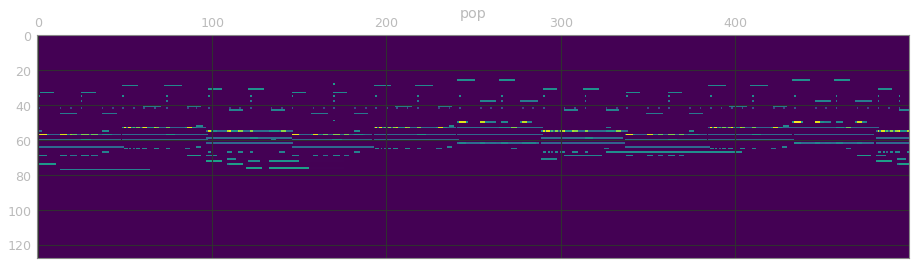

In [7]:
plot_piano_roll( load_piano_roll(train_valid_df.iloc[0,0],path), train_valid_df.iloc[0,1] )

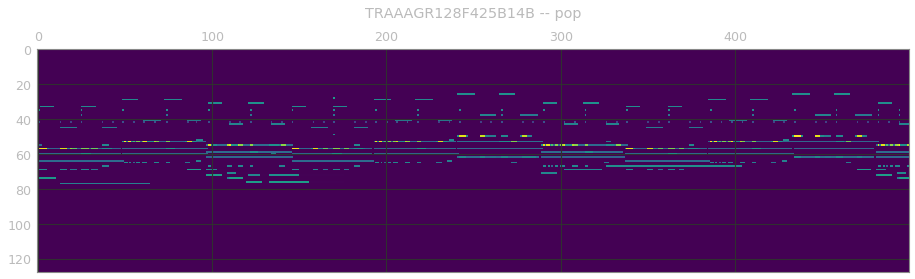

In [8]:
plot_piano_roll( load_piano_roll(train_valid_df.iloc[0,0],path), train_valid_df.iloc[0,1], train_valid_df.iloc[0,0] )

`torch.utils.data.Dataset` is an abstract class representing a dataset. A custom dataset should inherit Dataset and override the following methods:

    __len__ so that len(dataset) returns the size of the dataset.
    __getitem__ to support the indexing such that dataset[i] can be used to get ith sample

Let’s create a dataset class for our piano roll dataset. We will read the csv in `__init__` but leave the reading of images to `__getitem__`. This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of our dataset will be a tuple `(piano_roll:torch.Tensor, genre:str)`. 

In [9]:
df = pd.read_csv(path+'/train_valid.csv')
id_to_genre = dict(enumerate(set(df['Target'])))
genre_to_id = dict([(value, key) for key, value in id_to_genre.items()])
df.insert(2,'TargetID',[ genre_to_id[g] for g in df['Target'] ],True)

In [11]:
print(id_to_genre[30])
print(genre_to_id['jazz'])
df.head()

jazz
30


trackId   Target  TargetID  Valid
0  TRAAAGR128F425B14B      pop        16  False
1  TRAADKW128E079503A  poprock         7   True
2  TRAAFMT128F429DB58  poprock         7   True
3  TRAAGMC128F4292D0F  country        22  False
4  TRAALAH128E078234A  poprock         7  False

In [ ]:
#export
class PianorollDataset(Dataset):
    """
    Piano Roll dataset.
        Usage examples:
            pianoroll_ds = PianorollDataset(csv_file='train_valid.csv',base_path=path)
            valid_pr_ds = PianorollDataset(csv_file='train_valid.csv',base_path=path,valid_set=True)
    """

    def __init__(self, csv_file, base_path, valid_set = False, transform=None):
        """
        Args:
            @param csv_file (string): Path to the csv file with annotations.
            @param base_path (string): Directory with all the images and the csv.
            @param transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(base_path+'/'+csv_file)
        # restrict to the requested set
        self.valid_set = valid_set
        self.df = self.df.loc[self.df['Valid']==valid_set]
        self.base_path = base_path
        self.transform = transform
        
        # Now we need to instanciate our vocab from the unique genres
        self.id_to_genre = dict(enumerate(set(self.df['Target'])))
        self.genre_to_id = dict([(value, key) for key, value in self.id_to_genre.items()])
        self.df.insert(2,'TargetID',[ self.genre_to_id[g] for g in self.df['Target'] ],True)

    def load_piano_roll(self, song_name):
        t_indices = torch.load(self.base_path+'/'+song_name+'_indices.pt')
        t_values = torch.load(self.base_path+'/'+song_name+'_values.pt')
        t_sizes = torch.load(self.base_path+'/'+song_name+'_sizes.pt')
        return torch.sparse_coo_tensor(t_indices, t_values, t_sizes).to_dense()
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx): # wait, do we support lists of items?
            idx = idx.tolist()
        if isinstance(idx, list) and len(idx) > 1:
            raise NotImplementedError # .. no
            
        tensor_pr = self.load_piano_roll(self.df.iloc[idx,0])
        
        genre = self.df.iloc[idx,2]
        sample = (tensor_pr,torch.tensor(genre,dtype=torch.long))

        if self.transform:
            sample = self.transform(sample)

        return sample

In [13]:
pianoroll_ds = PianorollDataset(csv_file='train_valid.csv',base_path=path)
valid_pr_ds = PianorollDataset(csv_file='train_valid.csv',base_path=path,valid_set=True)

len(pianoroll_ds),len(valid_pr_ds)

(14620, 2714)

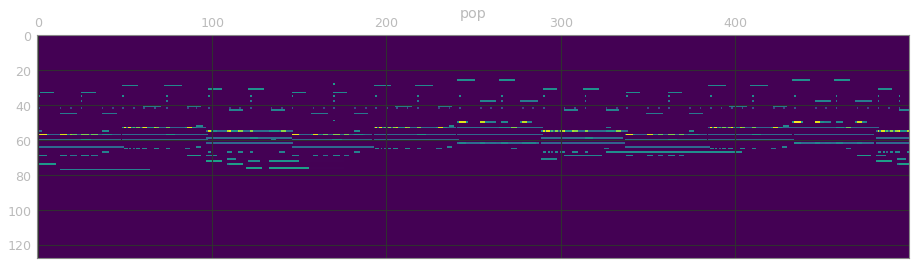

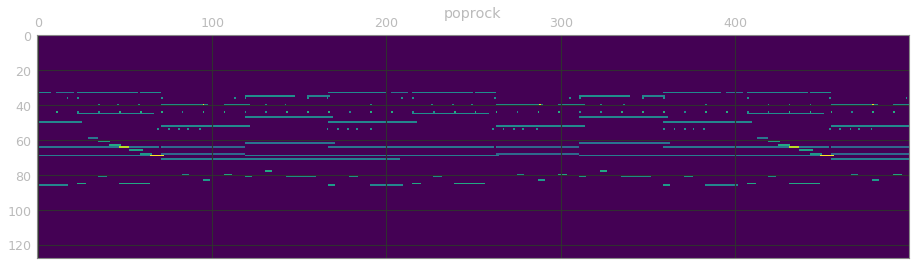

In [14]:
for i in range(len(pianoroll_ds)):
    x,y = pianoroll_ds[i]
    plot_piano_roll(x,pianoroll_ds.id_to_genre[y.item()])

    if i == 3:
        plt.show()
        break

Now we need:
 * Batching the data
 * Shuffling the data
 * Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is `collate_fn`. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

In [15]:
pianoroll_dl = DataLoader(pianoroll_ds, batch_size=4, shuffle=True, num_workers=4)
# wow just like that! nut it's SLOW!

In [ ]:
#export
# Util to show a batch
def show_pianoroll_batch(batch):
    x,y = batch
    for i in range(len(x)):
        plot_piano_roll(x[i],pianoroll_ds.id_to_genre[y[i].item()])

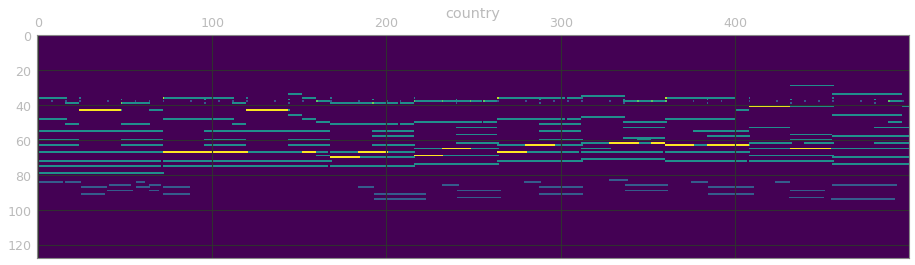

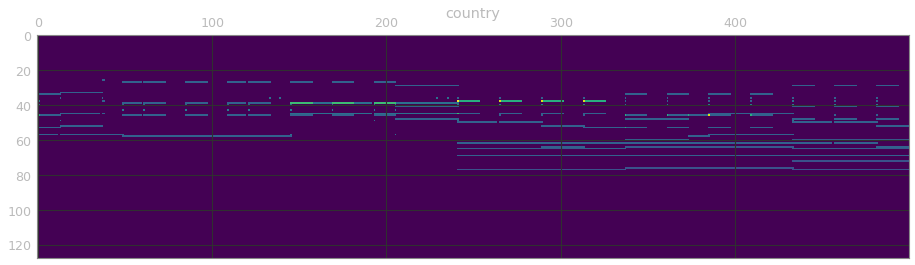

In [16]:
# normally you'd go like
# for b, samples in enumerate(pianoroll_dl):
#     ...
# but for now let's just  grab one batch

batch = next(iter(pianoroll_dl)) 
show_pianoroll_batch(batch)   


In [17]:
type(x), x.shape, type(y), y.shape

(torch.Tensor, torch.Size([5, 128, 10000]), torch.Tensor, torch.Size([]))

Export the notebook like you did for fast.ai, then create a new notebook with the Model and finally learn ignite and run a training loop!

In [3]:
!python3 notebook2script.py --fname=2_DataSet_and_Loader.ipynb --fname_out=nb_2.py

Converted 2_DataSet_and_Loader.ipynb to exp/asdasdasd.py
